In [2]:
%run script_simulation_oiii.py

In [15]:
%run simulation.py

In [19]:
%run model.py

In [20]:
def get_band(dust_model, params):
    sed = get_sed(dust_model, params)

    @np.vectorize
    def band(rsr, wavelength):
        return wavelength*integrate.trapz(rsr.ys*sed(rsr.xs)/rsr.xs, x=rsr.xs)

    return band

In [42]:
def get_lum0(data, params_, new_logcf):
    rsr, wavelength, lum, lum_unc = prepare_data(data)
    *params, _, mod = params_
    dust_model = dust_models[int(mod)]
    _, _, logcf = analysis(params_)

    factor = new_logcf - logcf

    band = get_band(dust_model, params)

    disk_amp, dust_temp, dust_lbol, av, cold_dust = params
    band_ = get_band(dust_model, [
        disk_amp,
        dust_temp,
        dust_lbol + factor,
        av,
        cold_dust + factor
    ])

    lum_ = np.log10(band_(rsr, wavelength)) + lum - np.log10(band(rsr, wavelength))

    return lum_

def get_lum1(data, params_, new_logcf):
    rsr, wavelength, lum, lum_unc = prepare_data(data)
    *params, _, mod = params_
    dust_model = dust_models[int(mod)]
    _, _, logcf = analysis(params_)

    factor = new_logcf - logcf

    band = get_band(dust_model, params)

    disk_amp, dust_temp, dust_lbol, av, cold_dust = params
    band_ = get_band(dust_model, [
        disk_amp,
        dust_temp,
        dust_lbol + factor,
        av,
        cold_dust + factor
    ])

    return np.log10(band_(rsr, wavelength))


def get_lum2(data, params_, new_logcf):
    rsr, wavelength, lum, lum_unc = prepare_data(data)
    *params, _, mod = params_
    dust_model = dust_models[int(mod)]
    _, _, logcf = analysis(params_)

    factor = new_logcf - logcf

    band = get_band(dust_model, params)

    disk_amp, dust_temp, dust_lbol, av, cold_dust = params
    band_ = get_band(dust_model, [
        disk_amp,
        dust_temp,
        dust_lbol + factor,
        av,
        cold_dust + factor
    ])

    return np.log10(band_(rsr, wavelength)) + lum_unc * np.random.randn(len(wavelength))

In [43]:
def get_data0(params):
    i, rand = params
    params_ = oiii_res[i]
    data = oiii[i]

    logew_norm, logcf_norm = rand
    logew = logew_norm * logews_std + logews_mean
    logcf = logcf_norm * logcfs_std + logcfs_mean

    return [get_lum0(data, params_, logcf), logew]


def get_data1(params):
    i, rand = params
    params_ = oiii_res[i]
    data = oiii[i]

    logew_norm, logcf_norm = rand
    logew = logew_norm * logews_std + logews_mean
    logcf = logcf_norm * logcfs_std + logcfs_mean

    return [get_lum1(data, params_, logcf), logew]


def get_data2(params):
    i, rand = params
    params_ = oiii_res[i]
    data = oiii[i]

    logew_norm, logcf_norm = rand
    logew = logew_norm * logews_std + logews_mean
    logcf = logcf_norm * logcfs_std + logcfs_mean

    return [get_lum2(data, params_, logcf), logew]

In [63]:
new_corr = get_new_corr(corr, -0.05)
rand = gen_rands(new_corr)

In [34]:
from scipy.interpolate import CubicSpline

In [44]:
def analysis_spline0(i):
    s = oiii[i]
    rsr, wavelength, _, lum_unc = prepare_data(s)
    lum = lum0[i]
    spline = CubicSpline(wavelength, lum)
    return [np.log10(spline(0.3)), np.log10(spline(np.linspace(1, 12))) - np.log10(spline(0.3))]

def analysis_spline1(i):
    s = oiii[i]
    rsr, wavelength, _, lum_unc = prepare_data(s)
    lum = lum1[i]
    spline = CubicSpline(wavelength, lum)
    return [np.log10(spline(0.3)), np.log10(spline(np.linspace(1, 12))) - np.log10(spline(0.3))]

def analysis_spline2(i):
    s = oiii[i]
    rsr, wavelength, _, lum_unc = prepare_data(s)
    lum = lum2[i]
    spline = CubicSpline(wavelength, lum)
    return [np.log10(spline(0.3)), np.log10(spline(np.linspace(1, 12))) - np.log10(spline(0.3))]

In [64]:
lum0, logew0 = zip(*[ get_data0([i, rand[i]]) for i in range(len(oiii))])

res_s = [analysis_spline0(i) for i in range(len(oiii))]

oiii_ans_s = np.array([r[1] for r in res_s])
loglbol_s = np.array([r[0] for r in res_s])
oiii_cors_s = [parcor([logew0, oiii_ans_s[:,i], loglbol_s, oiii["logbh_hb_vp06"]])[0,1]
for i in range(50)]
# oiii_cors_s_ = [np.corrcoef([logew0, oiii_ans_s[:,i]])[0,1]
# for i in range(50)]

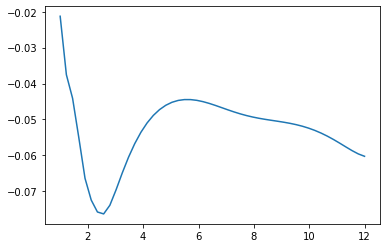

In [65]:
x = np.linspace(1,12)
plt.plot(x, oiii_cors_s)

In [66]:
lum1, logew1 = zip(*[ get_data1([i, rand[i]]) for i in range(len(oiii))])

res_s = [analysis_spline1(i) for i in range(len(oiii))]

oiii_ans_s = np.array([r[1] for r in res_s])
loglbol_s = np.array([r[0] for r in res_s])
oiii_cors_s = [parcor([logew1, oiii_ans_s[:,i], loglbol_s, oiii["logbh_hb_vp06"]])[0,1]
for i in range(50)]

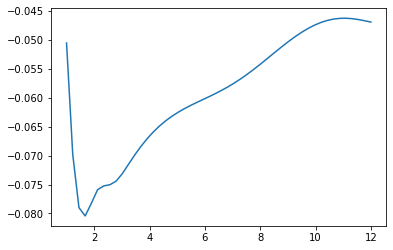

In [67]:
x = np.linspace(1,12)
plt.plot(x, oiii_cors_s)

In [68]:
lum2, logew2 = zip(*[ get_data2([i, rand[i]]) for i in range(len(oiii))])

res_s = [analysis_spline2(i) for i in range(len(oiii))]

oiii_ans_s = np.array([r[1] for r in res_s])
loglbol_s = np.array([r[0] for r in res_s])
oiii_cors_s = [parcor([logew2, oiii_ans_s[:,i], loglbol_s, oiii["logbh_hb_vp06"]])[0,1]
for i in range(50)]

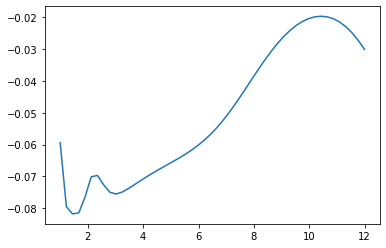

In [69]:
x = np.linspace(1,12)
plt.plot(x, oiii_cors_s)